# BTC Preditive Model

In [12]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [13]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [14]:
hist.head(5)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2019-01-20,3567.73,3754.65,3529.25,3729.78,49198.37,1.776285e+08
2019-01-21,3571.92,3599.83,3535.19,3567.73,36101.40,1.290009e+08
2019-01-22,3602.04,3635.69,3473.77,3571.92,53586.91,1.913552e+08
2019-01-23,3572.05,3631.15,3543.96,3602.04,37910.40,1.358642e+08
2019-01-24,3598.52,3616.33,3546.50,3572.05,31630.57,1.131552e+08


In [15]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [16]:
train, test = train_test_split(hist, test_size=0.2)

In [17]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

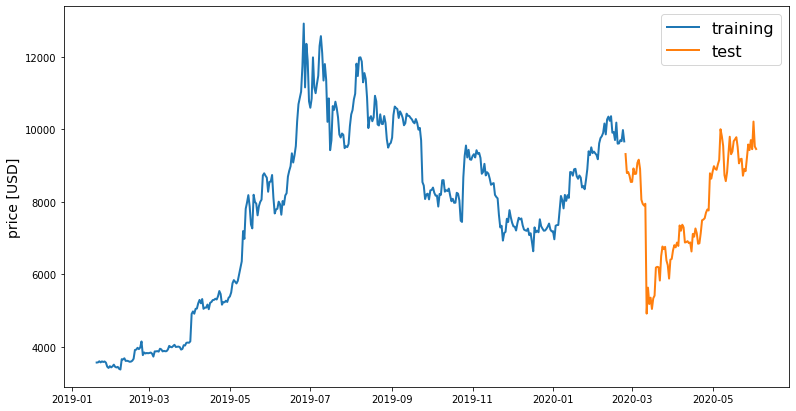

In [18]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [19]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [20]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)


In [21]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [22]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

#### Modeling Variable

In [23]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 600
batch_size = 32
loss = 'mse'
dropout = 0.1
optimizer = 'adam'

In [24]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [25]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/600
396/396 [==============================] - 1s 2ms/step - loss: 0.0047
Epoch 2/600
396/396 [==============================] - 0s 154us/step - loss: 0.0035
Epoch 3/600
396/396 [==============================] - 0s 158us/step - loss: 0.0029
Epoch 4/600
396/396 [==============================] - 0s 168us/step - loss: 0.0031
Epoch 5/600
396/396 [==============================] - 0s 164us/step - loss: 0.0025
Epoch 6/600
396/396 [==============================] - 0s 155us/step - loss: 0.0027
Epoch 7/600
396/396 [==============================] - 0s 155us/step - loss: 0.0025
Epoch 8/600
396/396 [==============================] - 0s 142us/step - loss: 0.0022
Epoch 9/600
396/396 [==============================] - 0s 160us/step - loss: 0.0022
Epoch 10/600
396/396 [==============================] - 0s 142us/step - loss: 0.0022
Epoch 11/600
396/396 [==============================] - 0s 142us/step - loss: 0.0021
Epoch 12/600
396/396 [==============================] - 0s 139us/step - loss

396/396 [==============================] - 0s 139us/step - loss: 0.0014
Epoch 98/600
396/396 [==============================] - 0s 136us/step - loss: 0.0013
Epoch 99/600
396/396 [==============================] - 0s 137us/step - loss: 0.0014
Epoch 100/600
396/396 [==============================] - 0s 134us/step - loss: 0.0014
Epoch 101/600
396/396 [==============================] - 0s 132us/step - loss: 0.0014
Epoch 102/600
396/396 [==============================] - 0s 127us/step - loss: 0.0014
Epoch 103/600
396/396 [==============================] - 0s 131us/step - loss: 0.0014
Epoch 104/600
396/396 [==============================] - 0s 133us/step - loss: 0.0014
Epoch 105/600
396/396 [==============================] - 0s 136us/step - loss: 0.0014
Epoch 106/600
396/396 [==============================] - 0s 134us/step - loss: 0.0015
Epoch 107/600
396/396 [==============================] - 0s 131us/step - loss: 0.0015
Epoch 108/600
396/396 [==============================] - 0s 133us/step

396/396 [==============================] - 0s 145us/step - loss: 0.0013
Epoch 193/600
396/396 [==============================] - 0s 143us/step - loss: 0.0013
Epoch 194/600
396/396 [==============================] - 0s 137us/step - loss: 0.0012
Epoch 195/600
396/396 [==============================] - 0s 134us/step - loss: 0.0012
Epoch 196/600
396/396 [==============================] - 0s 139us/step - loss: 0.0012
Epoch 197/600
396/396 [==============================] - 0s 135us/step - loss: 0.0012
Epoch 198/600
396/396 [==============================] - 0s 129us/step - loss: 0.0012
Epoch 199/600
396/396 [==============================] - 0s 130us/step - loss: 0.0013
Epoch 200/600
396/396 [==============================] - 0s 138us/step - loss: 0.0012
Epoch 201/600
396/396 [==============================] - 0s 133us/step - loss: 0.0012
Epoch 202/600
396/396 [==============================] - 0s 134us/step - loss: 0.0012
Epoch 203/600
396/396 [==============================] - 0s 133us/st

396/396 [==============================] - 0s 153us/step - loss: 0.0010
Epoch 288/600
396/396 [==============================] - 0s 140us/step - loss: 0.0011
Epoch 289/600
396/396 [==============================] - 0s 140us/step - loss: 0.0011
Epoch 290/600
396/396 [==============================] - 0s 133us/step - loss: 0.0011
Epoch 291/600
396/396 [==============================] - 0s 137us/step - loss: 0.0011
Epoch 292/600
396/396 [==============================] - 0s 140us/step - loss: 0.0011
Epoch 293/600
396/396 [==============================] - 0s 145us/step - loss: 0.0010
Epoch 294/600
396/396 [==============================] - 0s 139us/step - loss: 0.0011
Epoch 295/600
396/396 [==============================] - 0s 142us/step - loss: 0.0011
Epoch 296/600
396/396 [==============================] - 0s 136us/step - loss: 0.0011
Epoch 297/600
396/396 [==============================] - 0s 143us/step - loss: 0.0011
Epoch 298/600
396/396 [==============================] - 0s 141us/st

396/396 [==============================] - 0s 141us/step - loss: 9.8281e-04
Epoch 381/600
396/396 [==============================] - 0s 144us/step - loss: 9.5169e-04
Epoch 382/600
396/396 [==============================] - 0s 131us/step - loss: 9.4082e-04
Epoch 383/600
396/396 [==============================] - 0s 139us/step - loss: 9.4856e-04
Epoch 384/600
396/396 [==============================] - 0s 135us/step - loss: 9.4574e-04
Epoch 385/600
396/396 [==============================] - 0s 135us/step - loss: 9.9440e-04
Epoch 386/600
396/396 [==============================] - 0s 139us/step - loss: 9.9806e-04
Epoch 387/600
396/396 [==============================] - 0s 138us/step - loss: 9.4831e-04
Epoch 388/600
396/396 [==============================] - 0s 140us/step - loss: 9.9577e-04
Epoch 389/600
396/396 [==============================] - 0s 133us/step - loss: 9.1472e-04
Epoch 390/600
396/396 [==============================] - 0s 137us/step - loss: 9.8527e-04
Epoch 391/600
396/396 [=

396/396 [==============================] - 0s 143us/step - loss: 9.2709e-04
Epoch 472/600
396/396 [==============================] - 0s 137us/step - loss: 8.4979e-04
Epoch 473/600
396/396 [==============================] - 0s 137us/step - loss: 8.7651e-04
Epoch 474/600
396/396 [==============================] - 0s 132us/step - loss: 8.7993e-04
Epoch 475/600
396/396 [==============================] - 0s 130us/step - loss: 8.4467e-04
Epoch 476/600
396/396 [==============================] - 0s 131us/step - loss: 9.1393e-04
Epoch 477/600
396/396 [==============================] - 0s 133us/step - loss: 9.0569e-04
Epoch 478/600
396/396 [==============================] - 0s 138us/step - loss: 8.9941e-04
Epoch 479/600
396/396 [==============================] - 0s 137us/step - loss: 9.3844e-04
Epoch 480/600
396/396 [==============================] - 0s 134us/step - loss: 8.9821e-04
Epoch 481/600
396/396 [==============================] - 0s 136us/step - loss: 8.7432e-04
Epoch 482/600
396/396 [=

396/396 [==============================] - 0s 134us/step - loss: 8.1323e-04
Epoch 563/600
396/396 [==============================] - 0s 139us/step - loss: 8.4281e-04
Epoch 564/600
396/396 [==============================] - 0s 129us/step - loss: 8.9282e-04
Epoch 565/600
396/396 [==============================] - 0s 128us/step - loss: 8.1403e-04
Epoch 566/600
396/396 [==============================] - 0s 146us/step - loss: 8.2084e-04
Epoch 567/600
396/396 [==============================] - 0s 136us/step - loss: 7.9704e-04
Epoch 568/600
396/396 [==============================] - 0s 137us/step - loss: 7.8816e-04
Epoch 569/600
396/396 [==============================] - 0s 130us/step - loss: 8.2658e-04
Epoch 570/600
396/396 [==============================] - 0s 129us/step - loss: 7.7949e-04
Epoch 571/600
396/396 [==============================] - 0s 131us/step - loss: 7.9138e-04
Epoch 572/600
396/396 [==============================] - 0s 137us/step - loss: 7.7347e-04
Epoch 573/600
396/396 [=

In [26]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.05196272203890454

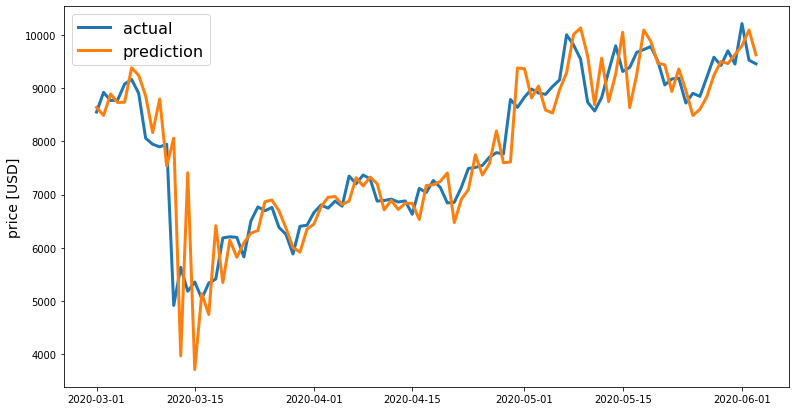

In [27]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

# ETH Predictive Model

In [28]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=ETH&tsym=USD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [29]:
hist.head(5)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2019-01-20,118.41,125.46,112.96,124.85,637823.68,76407912.20
2019-01-21,116.72,119.29,114.48,118.41,421391.55,49298484.48
2019-01-22,119.12,120.66,112.04,116.72,668659.65,78267602.06
2019-01-23,117.57,120.04,115.99,119.12,400801.53,47347740.34
2019-01-24,117.70,118.58,114.63,117.57,444538.31,51912659.64


In [30]:
train, test = train_test_split(hist, test_size=0.2)

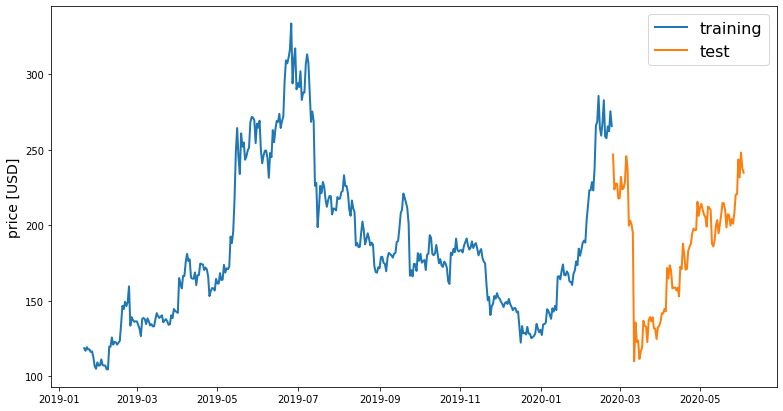

In [31]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [32]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [33]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/600
396/396 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 2/600
396/396 [==============================] - 0s 154us/step - loss: 0.0044
Epoch 3/600
396/396 [==============================] - 0s 143us/step - loss: 0.0039
Epoch 4/600
396/396 [==============================] - 0s 146us/step - loss: 0.0036
Epoch 5/600
396/396 [==============================] - 0s 142us/step - loss: 0.0033
Epoch 6/600
396/396 [==============================] - 0s 148us/step - loss: 0.0032
Epoch 7/600
396/396 [==============================] - 0s 144us/step - loss: 0.0031
Epoch 8/600
396/396 [==============================] - 0s 152us/step - loss: 0.0030
Epoch 9/600
396/396 [==============================] - 0s 140us/step - loss: 0.0029
Epoch 10/600
396/396 [==============================] - 0s 136us/step - loss: 0.0031
Epoch 11/600
396/396 [==============================] - 0s 140us/step - loss: 0.0026
Epoch 12/600
396/396 [==============================] - 0s 170us/step - loss

396/396 [==============================] - 0s 136us/step - loss: 0.0019
Epoch 98/600
396/396 [==============================] - 0s 144us/step - loss: 0.0019
Epoch 99/600
396/396 [==============================] - 0s 138us/step - loss: 0.0018
Epoch 100/600
396/396 [==============================] - 0s 137us/step - loss: 0.0019
Epoch 101/600
396/396 [==============================] - 0s 140us/step - loss: 0.0019
Epoch 102/600
396/396 [==============================] - 0s 139us/step - loss: 0.0018
Epoch 103/600
396/396 [==============================] - 0s 138us/step - loss: 0.0019
Epoch 104/600
396/396 [==============================] - 0s 146us/step - loss: 0.0019
Epoch 105/600
396/396 [==============================] - 0s 145us/step - loss: 0.0018
Epoch 106/600
396/396 [==============================] - 0s 144us/step - loss: 0.0019
Epoch 107/600
396/396 [==============================] - 0s 143us/step - loss: 0.0018
Epoch 108/600
396/396 [==============================] - 0s 144us/step

396/396 [==============================] - 0s 134us/step - loss: 0.0017
Epoch 193/600
396/396 [==============================] - 0s 138us/step - loss: 0.0017
Epoch 194/600
396/396 [==============================] - 0s 142us/step - loss: 0.0018
Epoch 195/600
396/396 [==============================] - 0s 136us/step - loss: 0.0017
Epoch 196/600
396/396 [==============================] - 0s 139us/step - loss: 0.0017
Epoch 197/600
396/396 [==============================] - 0s 141us/step - loss: 0.0017
Epoch 198/600
396/396 [==============================] - 0s 140us/step - loss: 0.0017
Epoch 199/600
396/396 [==============================] - 0s 140us/step - loss: 0.0017
Epoch 200/600
396/396 [==============================] - 0s 136us/step - loss: 0.0017
Epoch 201/600
396/396 [==============================] - 0s 136us/step - loss: 0.0017
Epoch 202/600
396/396 [==============================] - 0s 134us/step - loss: 0.0017
Epoch 203/600
396/396 [==============================] - 0s 140us/st

396/396 [==============================] - 0s 140us/step - loss: 0.0016
Epoch 288/600
396/396 [==============================] - 0s 138us/step - loss: 0.0015
Epoch 289/600
396/396 [==============================] - 0s 134us/step - loss: 0.0016
Epoch 290/600
396/396 [==============================] - 0s 132us/step - loss: 0.0015
Epoch 291/600
396/396 [==============================] - 0s 137us/step - loss: 0.0016
Epoch 292/600
396/396 [==============================] - 0s 142us/step - loss: 0.0015
Epoch 293/600
396/396 [==============================] - 0s 137us/step - loss: 0.0016
Epoch 294/600
396/396 [==============================] - 0s 137us/step - loss: 0.0015
Epoch 295/600
396/396 [==============================] - 0s 141us/step - loss: 0.0015
Epoch 296/600
396/396 [==============================] - 0s 136us/step - loss: 0.0015
Epoch 297/600
396/396 [==============================] - 0s 134us/step - loss: 0.0015
Epoch 298/600
396/396 [==============================] - 0s 137us/st

396/396 [==============================] - 0s 136us/step - loss: 0.0014
Epoch 383/600
396/396 [==============================] - 0s 139us/step - loss: 0.0015
Epoch 384/600
396/396 [==============================] - 0s 132us/step - loss: 0.0014
Epoch 385/600
396/396 [==============================] - 0s 140us/step - loss: 0.0015
Epoch 386/600
396/396 [==============================] - 0s 136us/step - loss: 0.0014
Epoch 387/600
396/396 [==============================] - 0s 140us/step - loss: 0.0015
Epoch 388/600
396/396 [==============================] - 0s 130us/step - loss: 0.0014
Epoch 389/600
396/396 [==============================] - 0s 133us/step - loss: 0.0014
Epoch 390/600
396/396 [==============================] - 0s 134us/step - loss: 0.0015
Epoch 391/600
396/396 [==============================] - 0s 132us/step - loss: 0.0015
Epoch 392/600
396/396 [==============================] - 0s 130us/step - loss: 0.0014
Epoch 393/600
396/396 [==============================] - 0s 135us/st

396/396 [==============================] - 0s 153us/step - loss: 0.0013
Epoch 478/600
396/396 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 479/600
396/396 [==============================] - 0s 158us/step - loss: 0.0014
Epoch 480/600
396/396 [==============================] - 0s 158us/step - loss: 0.0014
Epoch 481/600
396/396 [==============================] - 0s 159us/step - loss: 0.0014
Epoch 482/600
396/396 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 483/600
396/396 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 484/600
396/396 [==============================] - 0s 185us/step - loss: 0.0014
Epoch 485/600
396/396 [==============================] - 0s 181us/step - loss: 0.0013
Epoch 486/600
396/396 [==============================] - 0s 171us/step - loss: 0.0014
Epoch 487/600
396/396 [==============================] - 0s 155us/step - loss: 0.0013
Epoch 488/600
396/396 [==============================] - 0s 148us/st

396/396 [==============================] - 0s 139us/step - loss: 0.0013
Epoch 573/600
396/396 [==============================] - 0s 131us/step - loss: 0.0013
Epoch 574/600
396/396 [==============================] - 0s 139us/step - loss: 0.0013
Epoch 575/600
396/396 [==============================] - 0s 137us/step - loss: 0.0013
Epoch 576/600
396/396 [==============================] - 0s 138us/step - loss: 0.0014
Epoch 577/600
396/396 [==============================] - 0s 140us/step - loss: 0.0013
Epoch 578/600
396/396 [==============================] - 0s 140us/step - loss: 0.0013
Epoch 579/600
396/396 [==============================] - 0s 147us/step - loss: 0.0013
Epoch 580/600
396/396 [==============================] - 0s 138us/step - loss: 0.0013
Epoch 581/600
396/396 [==============================] - 0s 144us/step - loss: 0.0013
Epoch 582/600
396/396 [==============================] - 0s 154us/step - loss: 0.0013
Epoch 583/600
396/396 [==============================] - 0s 167us/st

In [34]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.046892369996584644

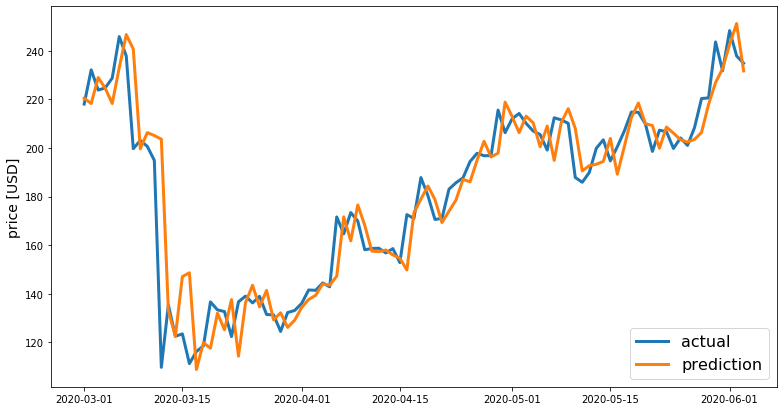

In [35]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

# LTC Preditive Model

In [36]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=LTC&tsym=USD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [37]:
hist.head(5)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2019-01-20,30.76,33.41,30.48,32.57,468941.07,14879390.29
2019-01-21,31.04,31.37,30.57,30.76,282351.26,8734012.47
2019-01-22,31.80,32.33,29.79,31.04,536491.36,16668444.36
2019-01-23,31.89,32.42,31.49,31.80,298354.18,9501120.11
2019-01-24,32.83,33.23,31.29,31.89,406607.68,13092655.34


In [38]:
train, test = train_test_split(hist, test_size=0.2)

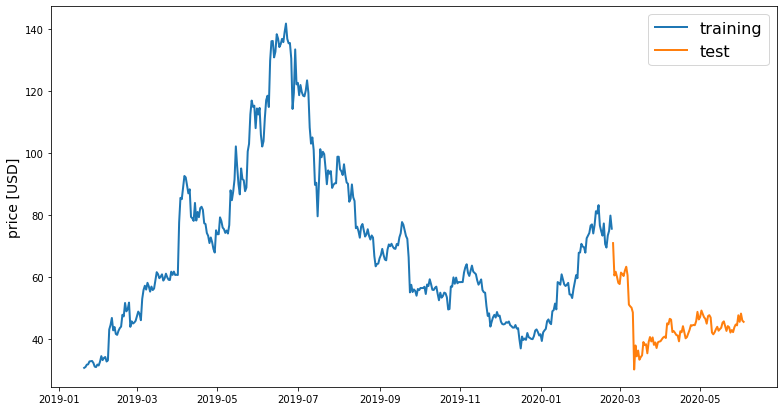

In [39]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [40]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [41]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/600
396/396 [==============================] - 0s 1ms/step - loss: 0.0210
Epoch 2/600
396/396 [==============================] - 0s 156us/step - loss: 0.0084
Epoch 3/600
396/396 [==============================] - 0s 161us/step - loss: 0.0060
Epoch 4/600
396/396 [==============================] - 0s 148us/step - loss: 0.0061
Epoch 5/600
396/396 [==============================] - 0s 142us/step - loss: 0.0053
Epoch 6/600
396/396 [==============================] - 0s 143us/step - loss: 0.0047
Epoch 7/600
396/396 [==============================] - 0s 135us/step - loss: 0.0042
Epoch 8/600
396/396 [==============================] - 0s 144us/step - loss: 0.0042
Epoch 9/600
396/396 [==============================] - 0s 148us/step - loss: 0.0041
Epoch 10/600
396/396 [==============================] - 0s 145us/step - loss: 0.0041
Epoch 11/600
396/396 [==============================] - 0s 139us/step - loss: 0.0039
Epoch 12/600
396/396 [==============================] - 0s 141us/step - loss

396/396 [==============================] - 0s 139us/step - loss: 0.0024
Epoch 98/600
396/396 [==============================] - 0s 139us/step - loss: 0.0023
Epoch 99/600
396/396 [==============================] - 0s 134us/step - loss: 0.0024
Epoch 100/600
396/396 [==============================] - 0s 134us/step - loss: 0.0025
Epoch 101/600
396/396 [==============================] - 0s 137us/step - loss: 0.0025
Epoch 102/600
396/396 [==============================] - 0s 135us/step - loss: 0.0026
Epoch 103/600
396/396 [==============================] - 0s 135us/step - loss: 0.0025
Epoch 104/600
396/396 [==============================] - 0s 138us/step - loss: 0.0024
Epoch 105/600
396/396 [==============================] - 0s 136us/step - loss: 0.0025
Epoch 106/600
396/396 [==============================] - 0s 131us/step - loss: 0.0024
Epoch 107/600
396/396 [==============================] - 0s 131us/step - loss: 0.0024
Epoch 108/600
396/396 [==============================] - 0s 132us/step

396/396 [==============================] - 0s 138us/step - loss: 0.0023
Epoch 193/600
396/396 [==============================] - 0s 137us/step - loss: 0.0023
Epoch 194/600
396/396 [==============================] - 0s 132us/step - loss: 0.0023
Epoch 195/600
396/396 [==============================] - 0s 131us/step - loss: 0.0024
Epoch 196/600
396/396 [==============================] - 0s 130us/step - loss: 0.0024
Epoch 197/600
396/396 [==============================] - 0s 136us/step - loss: 0.0022
Epoch 198/600
396/396 [==============================] - 0s 142us/step - loss: 0.0023
Epoch 199/600
396/396 [==============================] - 0s 134us/step - loss: 0.0023
Epoch 200/600
396/396 [==============================] - 0s 133us/step - loss: 0.0022
Epoch 201/600
396/396 [==============================] - 0s 137us/step - loss: 0.0023
Epoch 202/600
396/396 [==============================] - 0s 132us/step - loss: 0.0023
Epoch 203/600
396/396 [==============================] - 0s 134us/st

396/396 [==============================] - 0s 127us/step - loss: 0.0022
Epoch 288/600
396/396 [==============================] - 0s 137us/step - loss: 0.0022
Epoch 289/600
396/396 [==============================] - 0s 142us/step - loss: 0.0022
Epoch 290/600
396/396 [==============================] - 0s 129us/step - loss: 0.0022
Epoch 291/600
396/396 [==============================] - 0s 138us/step - loss: 0.0023
Epoch 292/600
396/396 [==============================] - 0s 128us/step - loss: 0.0022
Epoch 293/600
396/396 [==============================] - 0s 133us/step - loss: 0.0022
Epoch 294/600
396/396 [==============================] - 0s 128us/step - loss: 0.0022
Epoch 295/600
396/396 [==============================] - 0s 136us/step - loss: 0.0021
Epoch 296/600
396/396 [==============================] - 0s 137us/step - loss: 0.0022
Epoch 297/600
396/396 [==============================] - 0s 136us/step - loss: 0.0022
Epoch 298/600
396/396 [==============================] - 0s 128us/st

396/396 [==============================] - 0s 137us/step - loss: 0.0021
Epoch 383/600
396/396 [==============================] - 0s 139us/step - loss: 0.0021
Epoch 384/600
396/396 [==============================] - 0s 132us/step - loss: 0.0022
Epoch 385/600
396/396 [==============================] - 0s 133us/step - loss: 0.0022
Epoch 386/600
396/396 [==============================] - 0s 135us/step - loss: 0.0022
Epoch 387/600
396/396 [==============================] - 0s 130us/step - loss: 0.0021
Epoch 388/600
396/396 [==============================] - 0s 130us/step - loss: 0.0022
Epoch 389/600
396/396 [==============================] - 0s 129us/step - loss: 0.0021
Epoch 390/600
396/396 [==============================] - 0s 128us/step - loss: 0.0021
Epoch 391/600
396/396 [==============================] - 0s 131us/step - loss: 0.0021
Epoch 392/600
396/396 [==============================] - 0s 135us/step - loss: 0.0021
Epoch 393/600
396/396 [==============================] - 0s 133us/st

396/396 [==============================] - 0s 139us/step - loss: 0.0020
Epoch 478/600
396/396 [==============================] - 0s 136us/step - loss: 0.0020
Epoch 479/600
396/396 [==============================] - 0s 136us/step - loss: 0.0020
Epoch 480/600
396/396 [==============================] - 0s 135us/step - loss: 0.0021
Epoch 481/600
396/396 [==============================] - 0s 133us/step - loss: 0.0020
Epoch 482/600
396/396 [==============================] - 0s 141us/step - loss: 0.0021
Epoch 483/600
396/396 [==============================] - 0s 138us/step - loss: 0.0020
Epoch 484/600
396/396 [==============================] - 0s 131us/step - loss: 0.0020
Epoch 485/600
396/396 [==============================] - 0s 136us/step - loss: 0.0020
Epoch 486/600
396/396 [==============================] - 0s 137us/step - loss: 0.0020
Epoch 487/600
396/396 [==============================] - 0s 131us/step - loss: 0.0021
Epoch 488/600
396/396 [==============================] - 0s 134us/st

396/396 [==============================] - 0s 128us/step - loss: 0.0019
Epoch 573/600
396/396 [==============================] - 0s 135us/step - loss: 0.0019
Epoch 574/600
396/396 [==============================] - 0s 131us/step - loss: 0.0019
Epoch 575/600
396/396 [==============================] - 0s 132us/step - loss: 0.0019
Epoch 576/600
396/396 [==============================] - 0s 139us/step - loss: 0.0019
Epoch 577/600
396/396 [==============================] - 0s 133us/step - loss: 0.0019
Epoch 578/600
396/396 [==============================] - 0s 134us/step - loss: 0.0020
Epoch 579/600
396/396 [==============================] - 0s 134us/step - loss: 0.0019
Epoch 580/600
396/396 [==============================] - 0s 133us/step - loss: 0.0019
Epoch 581/600
396/396 [==============================] - 0s 130us/step - loss: 0.0019
Epoch 582/600
396/396 [==============================] - 0s 131us/step - loss: 0.0019
Epoch 583/600
396/396 [==============================] - 0s 136us/st

In [42]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.05375753396839348

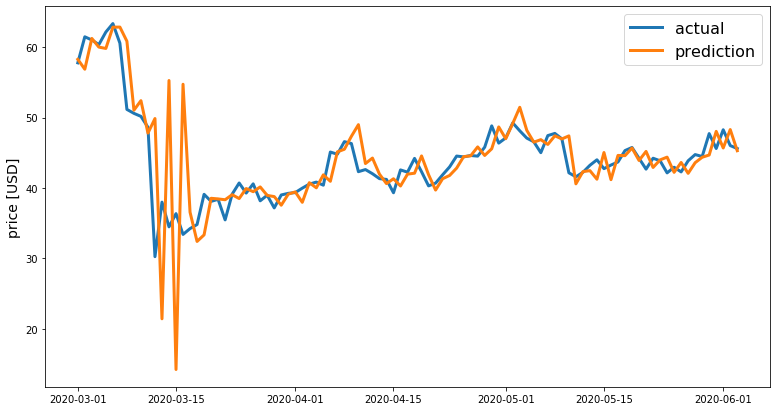

In [43]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)